In [1]:
import multiprocessing as mp
import cv2
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import Nystroem
from sklearn import svm
from joblib import Parallel, delayed, cpu_count
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots

In [3]:
with open("cache/training/neg_samples.pkl", "rb") as f:
    neg_samples = pickle.load(f)
with open("cache/training/waldo.pkl", "rb") as f:
    pos_waldo = pickle.load(f)
with open("cache/training/wenda.pkl", "rb") as f:
    pos_wenda = pickle.load(f)
with open("cache/training/wizard.pkl", "rb") as f:
    pos_wizard = pickle.load(f)


 ## Compute HOG feature descriptor for all samples

Sample image shape (128, 128), feature vector shape (12800,)
Sample image shape (128, 128), feature vector shape (12800,)
Sample image shape (128, 128), feature vector shape (12800,)
Sample image shape (128, 128), feature vector shape (12800,)


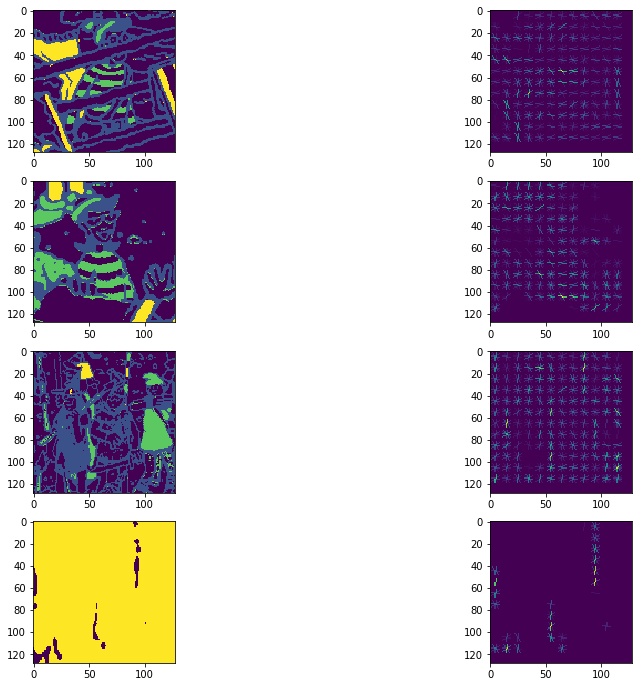

In [4]:

# DESCRIPTOR CONFIG
ORIENTATIONS = 8
PIXELS_PER_CELL = (10,10)
CELLS_PER_BLOCK = (5,5)

# viualize the descriptor once for each class
for i, s in enumerate([pos_waldo[0], pos_wenda[0], pos_wizard[0], neg_samples[0]]):
    feature, hog_image = hog(
        s,
        orientations=ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        visualize=True,
        multichannel=False,
    )
    print(
        "Sample image shape {}, feature vector shape {}".format(s.shape, feature.shape)
    )
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(s)
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(hog_image)

plt.show()



In [5]:
LABELS = {"waldo": 0, "wenda": 1, "wizard": 2, "negative": 3}


def hog_descriptor(samples, parallel=False):
    if parallel:
        return np.array(Parallel(n_jobs=cpu_count())(delayed(hog)(s,
                                                        orientations=ORIENTATIONS,
                                                        pixels_per_cell=PIXELS_PER_CELL,
                                                        cells_per_block=CELLS_PER_BLOCK,
                                                        visualize=False,
                                                        multichannel=False) for s in samples))
    else:
        return np.array(
            [
                hog(
                    s,
                    orientations=ORIENTATIONS,
                    pixels_per_cell=PIXELS_PER_CELL,
                    cells_per_block=CELLS_PER_BLOCK,
                    visualize=False,
                    multichannel=False,
                )
                for s in samples
            ]
    )


# transform samples into feature space
pf_wa = hog_descriptor(pos_waldo, parallel=True)
pf_we = hog_descriptor(pos_wenda, parallel=True)
pf_wi = hog_descriptor(pos_wizard, parallel=True)
nf_s = hog_descriptor(neg_samples, parallel=True)

X = np.concatenate((pf_wa, pf_we, pf_wi, nf_s), axis=0)
Y = np.concatenate(
    (
        np.full(pf_wa.shape[0], LABELS["waldo"]),
        np.full(pf_we.shape[0], LABELS["wenda"]),
        np.full(pf_wi.shape[0], LABELS["wizard"]),
        np.full(nf_s.shape[0], LABELS["negative"]),
    ),
    axis=0,
)

x_train, y_train = X, Y


In [6]:
print("training data shape: examples: {}, labels: {}".format(x_train.shape, y_train.shape))

pos = pf_wa.shape[0] + pf_we.shape[0] + pf_wi.shape[0]
neg = nf_s.shape[0]
tot = X.shape[0]

print('waldo: {} {:2.2f}%'.format(pf_wa.shape[0], pf_wa.shape[0]*100/tot))
print('wenda: {} {:2.2f}%'.format(pf_we.shape[0], pf_we.shape[0]*100/tot))
print('wizard: {} {:2.2f}%'.format(pf_wi.shape[0], pf_wi.shape[0]*100/tot))
print('negative: {} {:2.2f}%'.format(nf_s.shape[0], nf_s.shape[0]*100/tot))


print('positive examples:\t{}\t{:2.2f}% \nnegative examples\t{}\t{:2.2f}%'.format(pos, pos*100/tot, neg, neg*100/tot))


training data shape: examples: (1284, 12800), labels: (1284,)
waldo: 124 9.66%
wenda: 36 2.80%
wizard: 24 1.87%
negative: 1100 85.67%
positive examples:	184	14.33% 
negative examples	1100	85.67%


 ## Train Support Vector Machine Classifier (SVC)

In [15]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1e-3, 0.01, 0.1, 10, 100, 1000],
    'gamma': [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
}


print(x_train.shape, y_train.shape)

# This uses hyperparameter search to find the best model.
# Therefore it can be quite slow!
clf = GridSearchCV(svm.SVC(class_weight='balanced', decision_function_shape='ovo', random_state=0),
                  param_grid, refit=True, n_jobs=-1, cv=5)

clf = svm.SVC(C=100, gamma=0.01, kernel='rbf', class_weight='balanced', decision_function_shape='ovo', random_state=0, probability=True)

clf.fit(x_train, y_train)


print('best parameters:')
print(clf.best_params_)
print(clf.best_estimator_)

# save model to disk
with open("./Linear_SVM_V3.pkl", "wb") as f:
    pickle.dump(clf, f)


(1284, 12800) (1284,)


/Users/databook/miniconda3/envs/cvpr/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


 ## Evaluate Classifier

In [16]:
# load testing data
with open("cache/testing/waldo.pkl", "rb") as f:
    test_waldo = pickle.load(f)
with open("cache/testing/wenda.pkl", "rb") as f:
    test_wenda = pickle.load(f)
with open("cache/testing/wizard.pkl", "rb") as f:
    test_wizard = pickle.load(f)
with open("cache/testing/neg_samples.pkl", "rb") as f:
    test_neg_samples = pickle.load(f)[:30]

# transform samples into feature space
test_waldo = hog_descriptor(test_waldo, parallel=True)
test_wenda = hog_descriptor(test_wenda, parallel=True)
test_wizard = hog_descriptor(test_wizard, parallel=True)
test_neg_samples = hog_descriptor(test_neg_samples, parallel=True)

x_test = np.concatenate((test_waldo, test_wenda, test_wizard, test_neg_samples), axis=0)
y_test = np.concatenate(
    (
        np.full(test_waldo.shape[0], LABELS["waldo"]),
        np.full(test_wenda.shape[0], LABELS["wenda"]),
        np.full(test_wizard.shape[0], LABELS["wizard"]),
        np.full(test_neg_samples.shape[0], LABELS["negative"]),
    ),
    axis=0,
)


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(x_test),
                           target_names=LABELS))

              precision    recall  f1-score   support

       waldo       1.00      0.69      0.82        13
       wenda       0.83      0.71      0.77         7
      wizard       0.00      0.00      0.00         3
    negative       0.79      1.00      0.88        30

    accuracy                           0.83        53
   macro avg       0.66      0.60      0.62        53
weighted avg       0.80      0.83      0.80        53



/Users/databook/miniconda3/envs/cvpr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Display confusion matrix

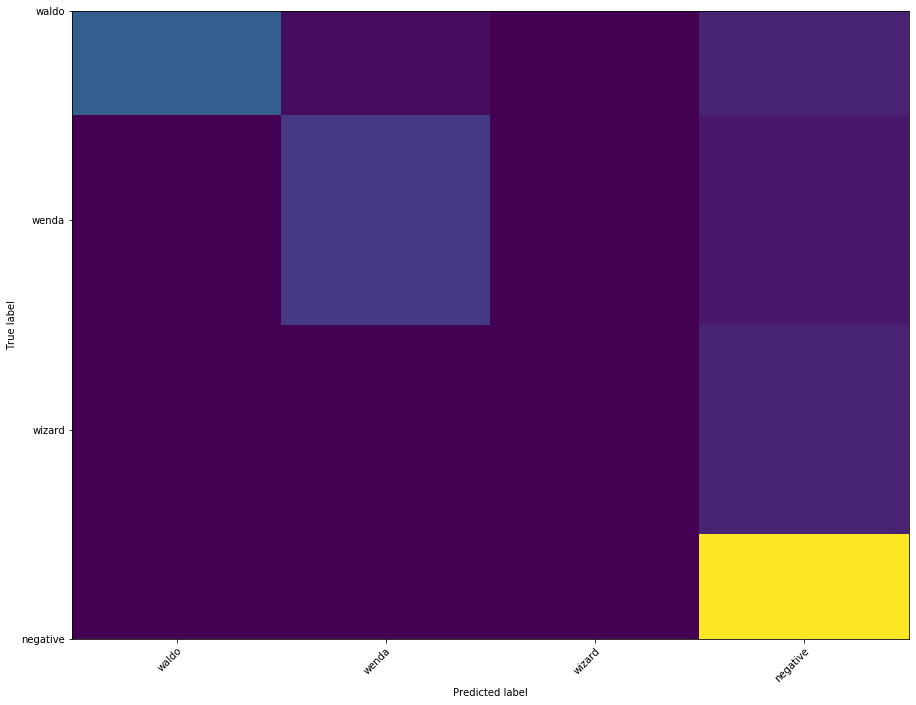

In [18]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
ax.imshow(conf_matrix, interpolation='nearest')
ax.set(xticks=np.arange(conf_matrix.shape[1]),
       yticks=np.arange(conf_matrix.shape[0]),
       xticklabels=LABELS, yticklabels=LABELS,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

 ## Try the classifier on one sample image

In [26]:
with open('cache/waldo45.pkl', 'rb') as f:
    sample = pickle.load(f)
    
with open('./Linear_SVM_V3_KMeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)
    K = 5
    
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d), dtype=np.uint8)
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i,j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def process_img(img):
    w,h,d = img.shape
    labels = kmeans.predict(np.reshape(img, (w*h,d)))
    
    white_idx =  np.argmin([np.linalg.norm(np.array([253, 253, 253]) - c) for c in kmeans.cluster_centers_])
    other_col_idx = np.argmin([np.linalg.norm(np.array([182,159,154]) - c) for c in kmeans.cluster_centers_])
    labels[labels == other_col_idx] = white_idx
    
    c = (np.arange(0,K) * 255 / (K-1)).astype(np.uint8)[np.newaxis].T
    cluster_centers = np.hstack([c,c,c])
    return recreate_image(cluster_centers, labels, w,h)[:,:,0]

img = sample['img']

In [60]:
#img = cv2.cvtColor(cv2.imread("datasets/JPEGImages/018.jpg"), cv2.COLOR_BGR2RGB)
def draw_bbox(ax, name, box, col='r'):
    r = patches.Rectangle((box[0], box[1]), 
                          box[2] - box[0],
                          box[3] - box[1],
                          linewidth=3,
                          edgecolor=col,
                          facecolor='none')
    ax.add_patch(r)
    ax.text(box[0], box[1], name,
            bbox={'facecolor': col, 'linewidth': 0})

def draw_annotation(ax, classes):
    for idx, cl in enumerate(classes):
        col = 'g'
        for box in cl['bounds']:
            draw_bbox(ax, cl['name'], box, col)

def dict_invert(key, d):
    return set(k for k, v in d.items() if v == key).pop()


def _transform_feature(img, ymin, ymax, xmin, xmax):
    window = cv2.resize(img[ymin:ymax, xmin:xmax], dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
    return (ymin, ymax, xmin, xmax, hog_descriptor([process_img(window)]))

def detect_img(img):
    img_y, img_x = img.shape[:2]
    size = 128
    
    with mp.Pool(mp.cpu_count()) as p:
        args = []
        for scale in range(1, 11):
            window_size = size * scale
            for y in range(0, img_y - window_size, window_size // 2):
                for x in range(0, img_x - window_size, window_size // 2):
                    args.append((img, y, y + window_size, x, x + window_size))

        print("transforming image windows into feature space")

        feature_vectors = p.starmap(_transform_feature, args)

        print('... done')
        print("detecting classes for windows")
        
    print('detections:')
    detections = []
    for feature_vector in feature_vectors:
        label = clf.predict(feature_vector[-1])
        proba = 1

        if LABELS['negative'] not in label:
            #proba = clf.predict_proba(feature_vector[-1])
            print(feature_vector[:-1], label, proba)
            detections.append((*feature_vector[:-1], label, proba))
            
    ax = plt.subplot(1, 1, 1)
    plt.imshow(img)
    # draw gound truth
    #draw_annotation(ax, sample['classes'])

    # draw detections
    for d in detections:
        w, h = d[3] - d[2], d[1] - d[0]
        p = patches.Rectangle((d[2], d[0]), w, h, edgecolor="r", facecolor="none", linewidth=3)
        ax.text(d[2], d[0], '{}: {:2.0f}%'.format(dict_invert(d[4], LABELS), d[5]*100),
            bbox={'facecolor': 'r', 'linewidth': 0},
           fontsize='small')
        ax.add_patch(p)


    plt.show()

transforming image windows into feature space
... done
detecting classes for windows
detections:
(384, 512, 704, 832) [0] 1
(576, 704, 64, 192) [0] 1


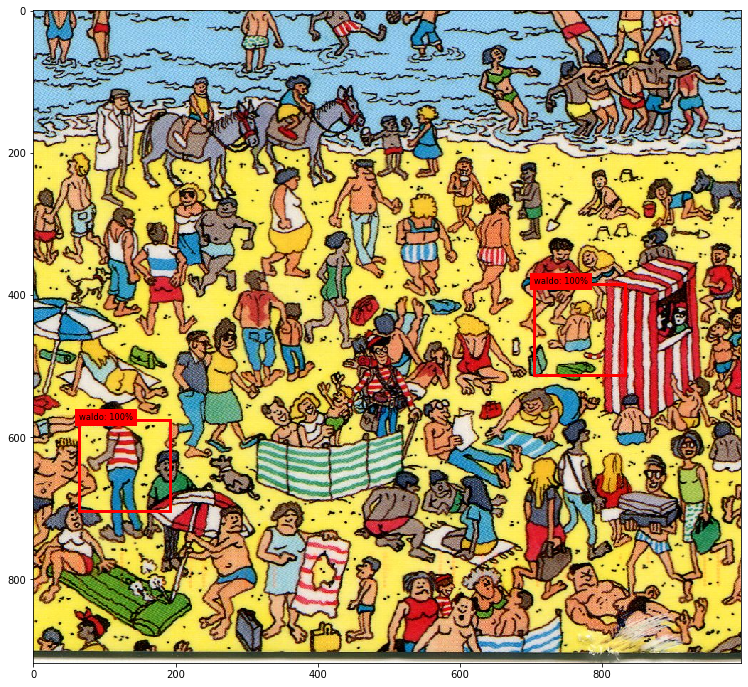

In [63]:
with open('cache/waldo45.pkl', 'rb') as f:
    sample = pickle.load(f)
    
detect_img(sample['img'])

transforming image windows into feature space
... done
detecting classes for windows
detections:
(384, 512, 1344, 1472) [0] 1
(832, 960, 896, 1024) [0] 1
(896, 1024, 896, 1024) [0] 1
(1088, 1216, 1792, 1920) [0] 1
(1920, 2176, 1152, 1408) [0] 1
(768, 1152, 768, 1152) [0] 1
(1728, 2112, 192, 576) [0] 1
(1728, 2112, 1152, 1536) [0] 1
(1792, 2304, 1024, 1536) [0] 1
(640, 1280, 640, 1280) [0] 1
(960, 1600, 640, 1280) [0] 1
(1600, 2240, 960, 1600) [0] 1
(1536, 2304, 0, 768) [0] 1


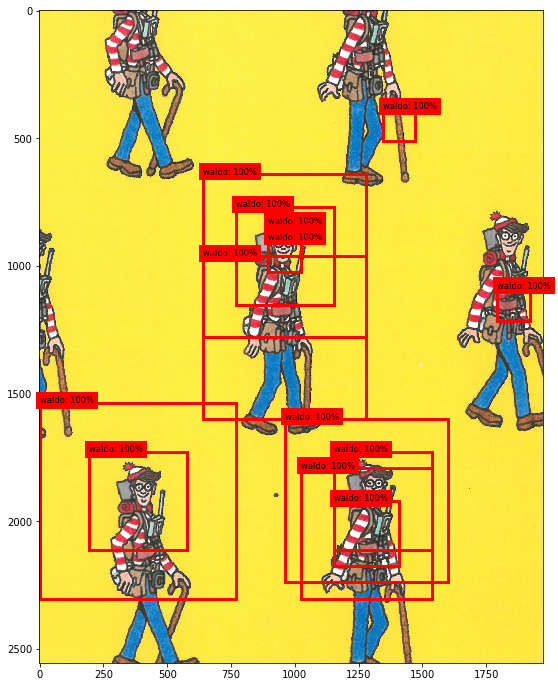

In [61]:
with open('cache/waldo29.pkl', 'rb') as f:
    sample = pickle.load(f)
    
detect_img(sample['img'])

transforming image windows into feature space
... done
detecting classes for windows
detections:


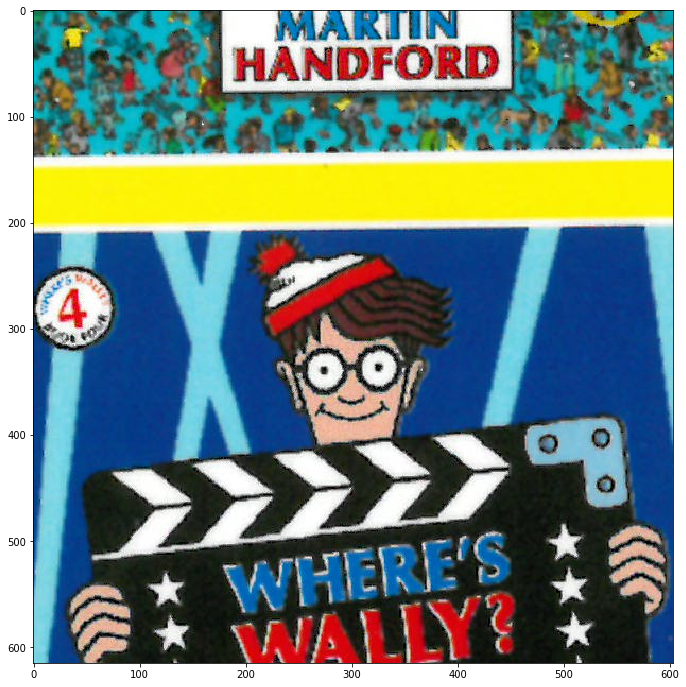

In [62]:
with open('cache/waldo48.pkl', 'rb') as f:
    sample = pickle.load(f)
    
detect_img(sample['img'])

transforming image windows into feature space
... done
detecting classes for windows
detections:
(128, 256, 128, 256) [0] 1


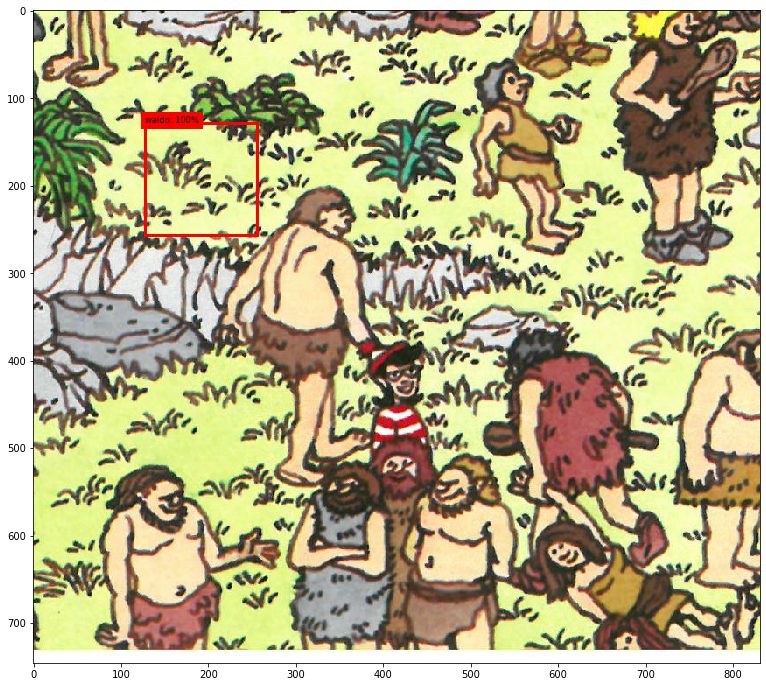

transforming image windows into feature space
... done
detecting classes for windows
detections:
(256, 384, 64, 192) [0] 1
(384, 512, 256, 384) [1] 1


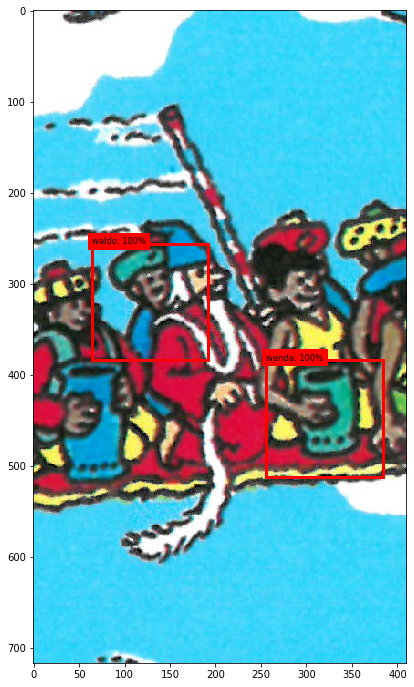

In [64]:
with open('cache/waldo3.pkl', 'rb') as f:
    sample = pickle.load(f)
    
detect_img(sample['img'])
with open('cache/waldo39.pkl', 'rb') as f:
    sample = pickle.load(f)
    
detect_img(sample['img'])

In [ ]:
img2 = cv2.cvtColor(cv2.imread("datasets/JPEGImages/018.jpg"), cv2.COLOR_BGR2RGB)
detect_img(img2)
